In [1]:
from functions import *

In [2]:
# Define parameters 
num_monomers = 20
mean_bond_length = 1
std_bond_length = 20
gaussian_noise_std = 10 

In [3]:
# Generate templates that are at the local minima 
num_templates = 2
template_chain_list = [generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length) for i in range(num_templates)]

In [4]:
template_dmaps = jnp.array([generate_flatten_distance_map(t) for t in template_chain_list])

INFO:jax._src.lib.xla_bridge:Remote TPU is not linked into jax; skipping remote TPU.
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'


INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter Host
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:jax._src.lib.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [5]:
# Generate a spectrum of structures between two template chains 
weight_list = jnp.linspace(1, 0, 11)
spectrum_structure_list = [x*template_dmaps[0] + (1-x)*template_dmaps[1] for x in weight_list]

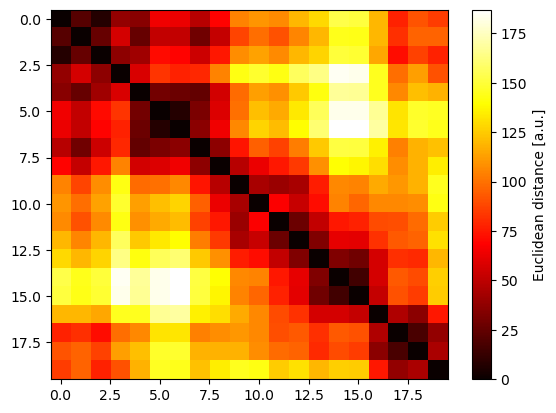

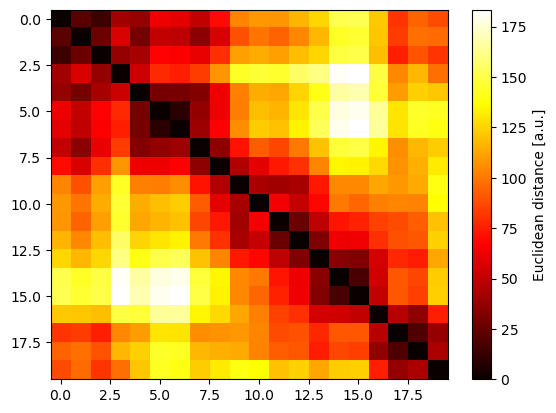

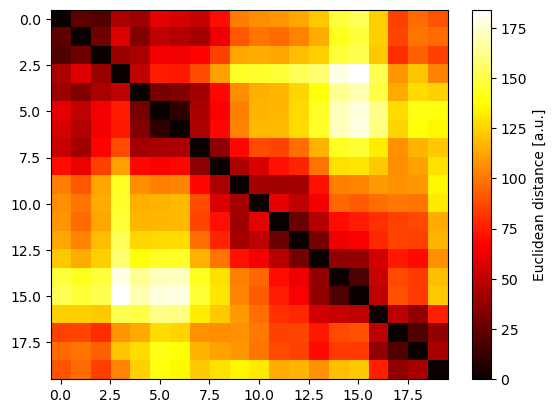

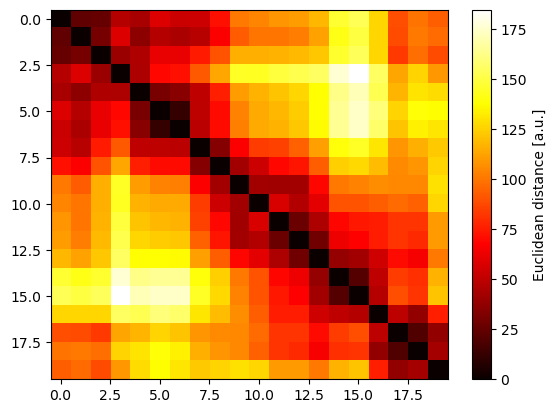

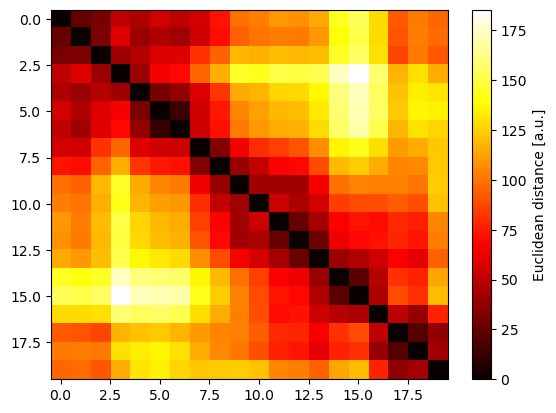

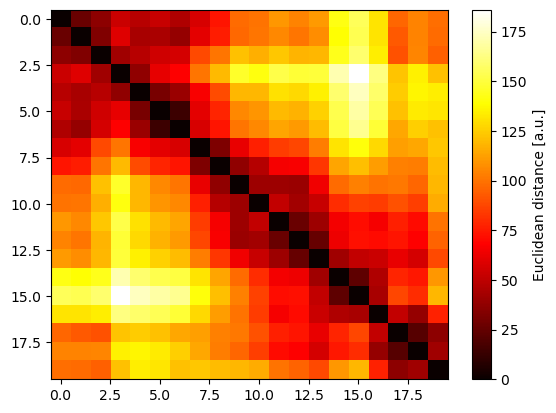

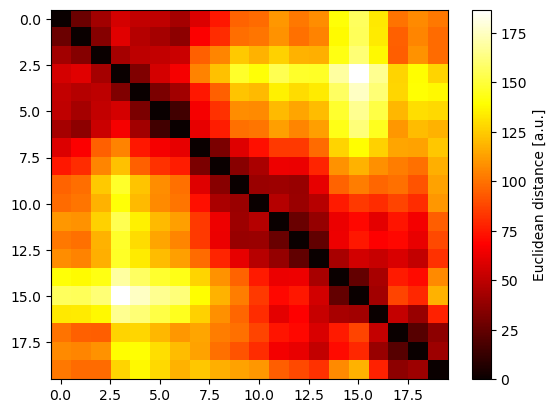

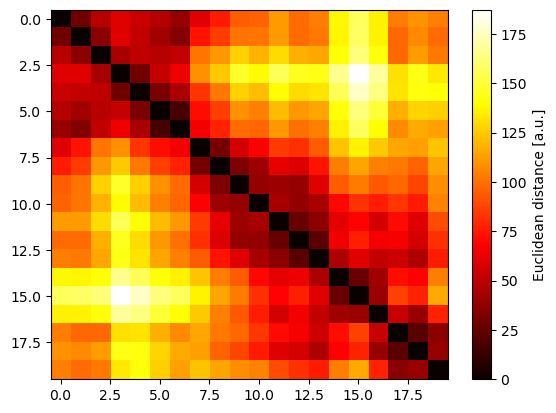

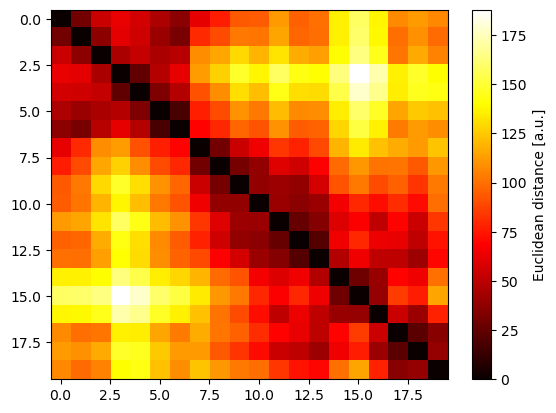

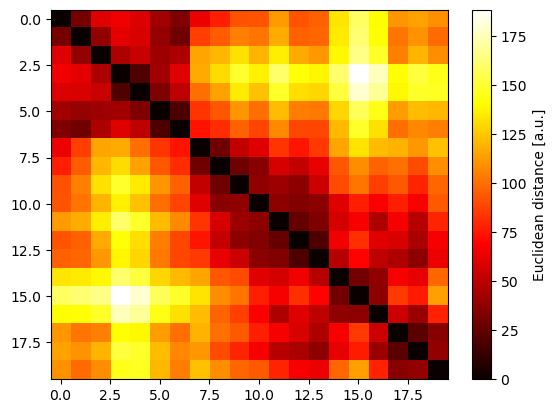

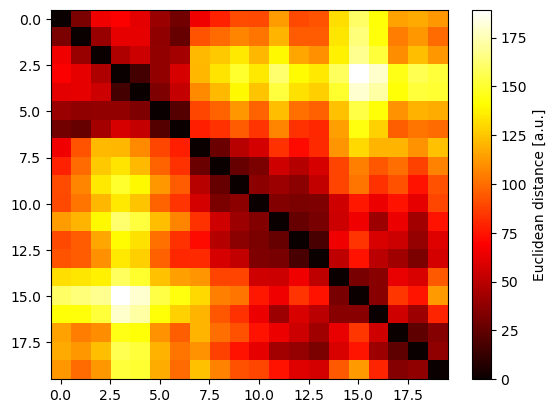

In [6]:
for dmap in spectrum_structure_list:
    visualize_dmap(dmap.reshape(20, 20))

In [40]:
mean = 0
std = gaussian_noise_std
dmap_size = [num_monomers, num_monomers]


num_observation_list = [100, 100, 100, 100, 100, 
                        100, 100, 100, 100, 100, 100]

observations_flatten = []
for i in range(len(spectrum_structure_list)):
    for j in range(num_observation_list[i]):
        noise = np.random.normal(mean, std, dmap_size)
        noise[np.eye(num_monomers).astype(bool)] = 0
        noisy_flatten_dmap = spectrum_structure_list[i] + noise.reshape(-1)
        observations_flatten.append(noisy_flatten_dmap)

In [41]:
observation_class_list = []
for i in range(len(spectrum_structure_list)):
    for j in range(num_observation_list[i]):
        if i != 5:
            observation_class_list.append(int(i < 6))
        else:
            observation_class_list.append(int(j < 5))

In [42]:
observation_class_list_OG = []
for i in range(len(spectrum_structure_list)):
    for j in range(num_observation_list[i]):
        observation_class_list_OG.append(i)

In [43]:
def generate_posterior_parallelize(templates, observations_flatten, template_weights, weight_renormalization=1000):
    """
    """
    templates_flatten = [generate_flatten_distance_map(t) for t in templates]
    
    templates_flatten = jnp.array(templates_flatten)
    observations_flatten = jnp.array(observations_flatten)
    
    template_weights = jnp.array(template_weights)
    
    weight_prior = 1/len(template_weights) 
    
    # Generate grid index combination
    template_info_indices = jnp.arange(len(templates_flatten))
    observation_info_indices = jnp.arange(len(observations_flatten))
    t_ind, o_ind = jnp.meshgrid(template_info_indices, observation_info_indices)
    
    total_posterior = 0
    
    t_ind = t_ind.flatten()
    o_ind = o_ind.flatten()
    
    # jax.debug.print("Weights at current iteration: {y}", y=template_weights)
    def calculate_rhs(t_ind, o_ind):
        val = 0 
        o = observations_flatten[o_ind]
        t = templates_flatten[t_ind]
        alpha = template_weights[t_ind]
        
        val += loglikelihood(o, t, measurement_error, num_probes)

        val += logprior(t, num_probes)

        # This is the correct one 
        # But the scaling between alpha and weight priors and logliokelihood are so different 
        # val += jnp.log(alpha + 1e-32) * weight_renormalization 
        val += jnp.log(jnp.abs(alpha) + 1e-32) * weight_renormalization  # use jnp.abs to make sure that each alpha does not go to 0
        val += jnp.log(weight_prior) * weight_renormalization
           
        return val 
    
    def calculate_posterior(i):
        return jscipy.special.logsumexp(jnp.where(o_ind == i, curr_obs_list, -jnp.inf))
    
    curr_obs_list = jnp.array(jax.vmap(calculate_rhs)(t_ind, o_ind))
    
    total_posterior = jnp.sum(jax.vmap(calculate_posterior)(jnp.arange(len(observations_flatten))))

    return total_posterior

def structure_neg_objective_parallelize(observations_flatten):
    """
    """ 
    templates = template_chain_list
    template_weights = num_observation_list
    return -generate_posterior_parallelize(templates, observations_flatten, template_weights)
    

In [44]:
measurement_error = gaussian_noise_std
num_probes = num_monomers

structure_neg_objective_parallelize(observations_flatten)

Array(-581604.4, dtype=float32)

In [45]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative
pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(observations_flatten)

INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 103.36865234375 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 44.78080368041992 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 49.94450759887695 Stepsize:8.0 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 51.86241912841797 Stepsize:16.0 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 49.30923080444336 Stepsize:32.0 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 39.890628814697266 Stepsize:64.0 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 21.74650001525879 Stepsize:128.0 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 8.552668571472168 Stepsize:128.0 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 0.09220798313617706 Stepsize:128.0 
INFO: jaxopt.Proxi

In [56]:
import cProfile

# Create a profile object
profile = cProfile.Profile()
profile.enable()
pg = ProjectedGradient(fun=structure_neg_objective_parallelize, projection=projection_non_negative, implicit_diff=True, verbose=True)
pg_sol = pg.run(observations_flatten)
profile.disable()


INFO: jaxopt.ProximalGradient: Iter: 1 Distance btw Iterates (stop. crit.): 103.36865234375 Stepsize:2.0 
INFO: jaxopt.ProximalGradient: Iter: 2 Distance btw Iterates (stop. crit.): 44.78080368041992 Stepsize:4.0 
INFO: jaxopt.ProximalGradient: Iter: 3 Distance btw Iterates (stop. crit.): 49.94450759887695 Stepsize:8.0 
INFO: jaxopt.ProximalGradient: Iter: 4 Distance btw Iterates (stop. crit.): 51.86241912841797 Stepsize:16.0 
INFO: jaxopt.ProximalGradient: Iter: 5 Distance btw Iterates (stop. crit.): 49.30923080444336 Stepsize:32.0 
INFO: jaxopt.ProximalGradient: Iter: 6 Distance btw Iterates (stop. crit.): 39.890628814697266 Stepsize:64.0 
INFO: jaxopt.ProximalGradient: Iter: 7 Distance btw Iterates (stop. crit.): 21.74650001525879 Stepsize:128.0 
INFO: jaxopt.ProximalGradient: Iter: 8 Distance btw Iterates (stop. crit.): 8.552668571472168 Stepsize:128.0 
INFO: jaxopt.ProximalGradient: Iter: 9 Distance btw Iterates (stop. crit.): 0.09220798313617706 Stepsize:128.0 
INFO: jaxopt.Proxi

NameError: name 'pstats' is not defined

In [57]:
import pstats
# Create a Stats object
stats = pstats.Stats(profile)
stats.strip_dirs()
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

         130090064 function calls (127934710 primitive calls) in 336.419 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2  230.655  115.327  230.655  115.327 dispatch.py:1016(backend_compile)
        2    7.586    3.793    7.609    3.805 pxla.py:2082(_call_with_tokens)
1712252/1712240    3.632    0.000   12.821    0.000 util.py:73(safe_map)
  4134319    2.753    0.000    3.984    0.000 config.py:243(get_state)
10893076/10893024    2.249    0.000    3.788    0.000 {built-in method builtins.isinstance}
   968400    2.057    0.000    4.540    0.000 __init__.py:430(_replace)
  1223746    1.934    0.000    1.934    0.000 {built-in method __new__ of type object at 0x155555306c40}
  17686/2    1.801    0.000   21.832   10.916 mlir.py:1067(jaxpr_subcomp)
   702427    1.744    0.000    7.192    0.000 dtypes.py:616(dtype)
1049178/1046964    1.734    0.000    3.752    0.000 {built-in method numpy.core._multiarray_umath.implem

In [46]:
sol = pg_sol.params


In [12]:
reducer = umap.UMAP()

Text(0.5, 1.0, 'UMAP projection of distance maps')

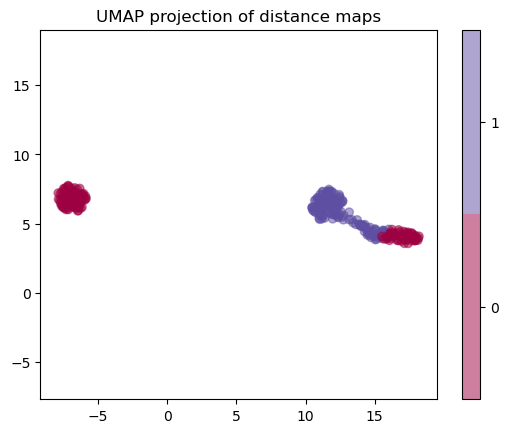

In [13]:
reducer.fit(sol)
embedding = reducer.transform(sol)
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=observation_class_list, 
    cmap='Spectral',
    alpha=0.5)
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks(np.arange(2))
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of distance maps')

In [16]:
# Use PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

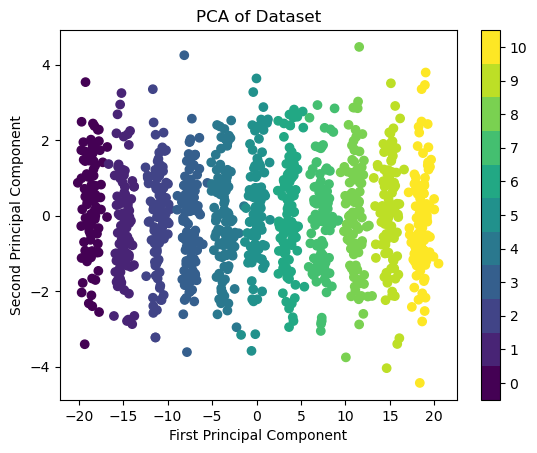

In [47]:
# Visualize PCA of original structures 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(observations_flatten)

# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=observation_class_list_OG)
plt.colorbar(boundaries=np.arange(len(spectrum_structure_list)+1)-0.5).set_ticks(np.arange(len(spectrum_structure_list)))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

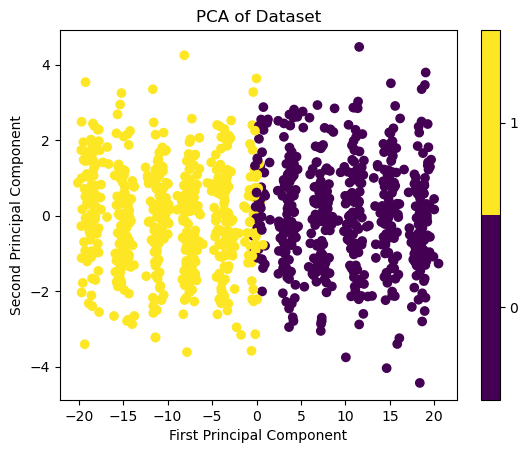

In [54]:
# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=svm_result)
plt.colorbar(boundaries=np.arange(2+1)-0.5).set_ticks(np.arange(2))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [38]:
np.unique(svm_result)

array([0, 1])

In [18]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sol)

In [19]:
# Apply PCA
pca = PCA(n_components=2)  # Choose the number of components
X_pca = pca.fit_transform(X_scaled)

Explained variance ratio: [9.98894956e-01 3.45669914e-04]
Principal components:
 [[-1.27969782e+01  9.00776792e-02]
 [-1.28192291e+01 -4.41419054e-01]
 [-1.28112170e+01  4.63432056e-01]
 [-1.28285545e+01 -4.12116381e-01]
 [-1.28073845e+01 -2.96700961e-01]
 [-1.27918532e+01  4.48237440e-01]
 [-1.27578449e+01  4.63458121e-01]
 [-1.28008481e+01  2.36414709e-01]
 [-1.28017962e+01 -4.18355162e-03]
 [-1.27789681e+01  3.01592764e-02]
 [-1.28187776e+01  2.34128379e-01]
 [-1.27889703e+01  6.71821901e-01]
 [-1.28776746e+01  2.48597683e-01]
 [-1.28002989e+01  3.27895397e-01]
 [-1.28299269e+01 -1.21699891e-01]
 [-1.27681473e+01  4.50144633e-02]
 [-1.28817770e+01 -6.24010942e-01]
 [-1.27687850e+01  8.06276212e-02]
 [-1.27642627e+01  4.29860601e-01]
 [-1.28348280e+01  8.85735548e-02]
 [-1.27720909e+01  4.36736381e-01]
 [-1.28290465e+01 -4.55854317e-01]
 [-1.27842225e+01  2.75002935e-02]
 [-1.28366892e+01  8.58875529e-02]
 [-1.28465871e+01 -4.73463906e-01]
 [-1.28136901e+01 -5.21369156e-02]
 [-1.2773

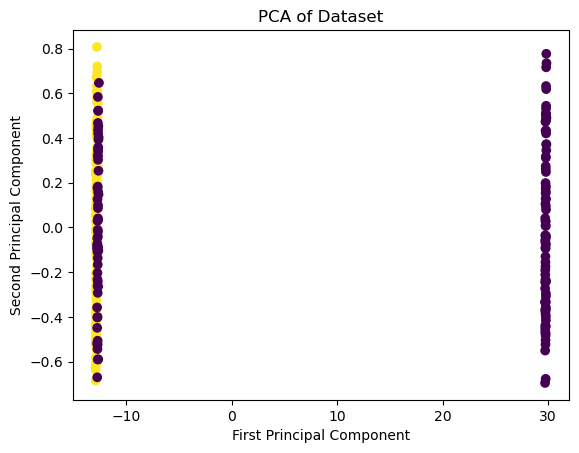

In [22]:
# View results
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Principal components:\n", X_pca)

# Visualize results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=observation_class_list)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Dataset')
plt.show()

In [48]:
# Use SVM to classify results into two classes 

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [49]:
X = sol
y = observation_class_list
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [50]:
clf = svm.SVC(kernel='linear', C=1)  # You can choose other kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [51]:
# Make predictions
y_pred = clf.predict(X_test)

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9409090909090909
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       116
           1       0.90      0.99      0.94       104

    accuracy                           0.94       220
   macro avg       0.94      0.94      0.94       220
weighted avg       0.95      0.94      0.94       220



In [53]:
svm_result = clf.predict(X)

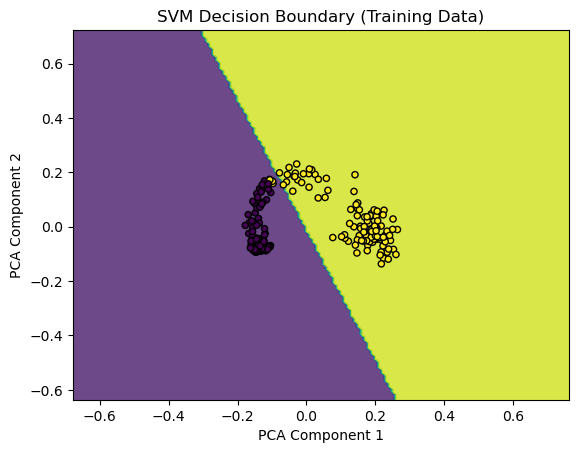

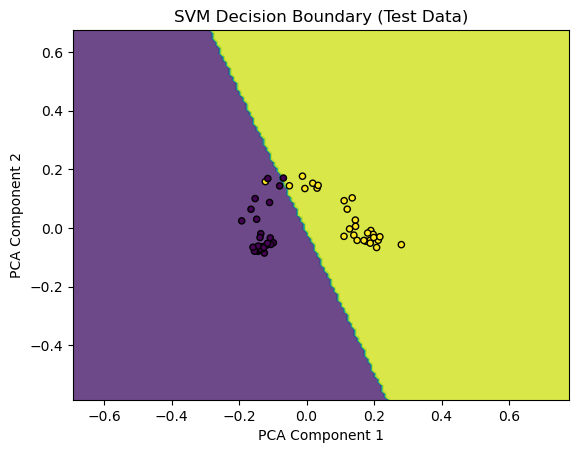

In [38]:
from sklearn.decomposition import PCA
# Train the SVM model
clf = svm.SVC(kernel='linear', C=1.0)  # You can choose other kernels like 'rbf', 'poly', etc.
clf.fit(X_train, y_train)

# Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Retrain SVM on reduced data
clf_pca = svm.SVC(kernel='linear', C=1.0)
clf_pca.fit(X_train_pca, y_train)

# Function to plot decision boundary
def plot_decision_boundary(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Plot the decision boundary for training data
plot_decision_boundary(X_train_pca, y_train, clf_pca, "SVM Decision Boundary (Training Data)")

# Plot the decision boundary for test data
plot_decision_boundary(X_test_pca, y_test, clf_pca, "SVM Decision Boundary (Test Data)")